# Импорт

In [1]:
import sys
print ( sys.base_prefix )

/usr


In [2]:
import numpy as np
import pandas as pd
import time
import datetime
import dask.dataframe as dd
import gc

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sklearn
import xgboost
import hyperopt
import shap
from sklearn.feature_selection import chi2
import dask.dataframe as dd

In [4]:
# Install Boruta
!pip install boruta

# Install feature-engine
!pip install feature-engine

# Install hyperopt (if you need it)
!pip install hyperopt

!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00


In [5]:
from xgboost import XGBClassifier, plot_importance

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE

from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval
from hyperopt import rand

from boruta import BorutaPy
from feature_engine.selection import DropConstantFeatures

from sklearn import metrics
# metrics.get_scorer_names()
import zipfile
import os
from google.colab import drive
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler

In [6]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 14.2 MB/s eta 0:00:00


In [7]:
import optuna

In [120]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import StratifiedKFold

# Загрузка данных

In [8]:
print( "pd: ", pd.__version__, "np: ", np.__version__, "xgb: ", xgboost.__version__, "skl: ", sklearn.__version__, "hpt: ", hyperopt.__version__ )

pd:  2.2.2 np:  2.0.2 xgb:  2.1.4 skl:  1.6.1 hpt:  0.2.7


In [9]:
# selection = DropConstantFeatures( tol = 1 or less )
# selection.fit( ... )
# selection.features_to_drop_
# selection.transform( ... )

In [10]:
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:

file_path = '/content/drive/MyDrive/DataStore/medii/SalDeaC.parquet-20250705T222734Z-1-001.zip'
print(f"File size: {os.path.getsize(file_path)} bytes")

File size: 734753232 bytes


In [12]:
zip_path = '/content/drive/MyDrive/DataStore/medii/SalDeaC.parquet-20250705T222734Z-1-001.zip'
extract_path = '/content/drive/MyDrive/DataStore/medii/extracted/'

# Create directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List extracted files
extracted_files = os.listdir(extract_path)
print("Extracted files:", extracted_files)



Extracted files: ['SalDeaC.parquet']


# Подготовка данных

In [13]:
cols_to_load = [
    'GUID_client', 'TrueClient', 'DateFirst_cl', 'DateLast_cl',

    'PurchaseData', 'Sum', 'SumNoDiscount', 'discount', 'Quantity', 'Operation',

    'Days_btw_deals',

    'SpecialtyGroupCRM',

    "MacrogroupRS_deal",

    "Harmony_deal", "ClassCompression_deal", "Date",

    'TypeRetailSales', 'MEDI_GMBH_deal', 'KM_deal', 'OrderStatus_deal', 'Operation_deal', 'DiscountName', 'City_deal'
]
#'Seller', 'GUID_warehouse', 'GUID_DiscountCard', 'WH_deal', "MicrogroupRS_deal"

In [14]:
%%time

ddf_sales = dd.read_parquet(r'/content/drive/MyDrive/DataStore/medii/extracted/SalDeaC.parquet', engine='pyarrow', columns=cols_to_load)
#, columns=cols_to_load

start_date = pd.to_datetime('2021-06-01')
end_date = pd.to_datetime('2024-01-01')

ddf_sales['Date'] = dd.to_datetime(ddf_sales['Date'])
ddf_sales['DateLast_cl'] = dd.to_datetime(ddf_sales['DateLast_cl'])
ddf_sales['DateFirst_cl'] = dd.to_datetime(ddf_sales['DateFirst_cl'])


mask = ( (ddf_sales['Date'] >= start_date) & (ddf_sales['Date'] <= end_date) )

ddf_filtered = ddf_sales[mask]

all_chunks = []
for partition in ddf_filtered.partitions:
    df_chunk = partition.compute()
    all_chunks.append(df_chunk)
    del df_chunk  # Release memory after each chunk

df_saldeac = pd.concat(all_chunks, ignore_index=True)
del all_chunks # Release memory
gc.collect()

df_saldeac.shape

CPU times: user 30.1 s, sys: 1.07 s, total: 31.1 s
Wall time: 37.2 s


(1160884, 23)

In [15]:
df_saldeac.describe()

,TrueClient,DateFirst_cl,DateLast_cl,PurchaseData,Sum,SumNoDiscount,discount,Quantity,Date,OrderStatus_deal
count,1.160884e+06,1160884,1160884,1160884,1.160884e+06,1.160884e+06,1.160884e+06,1.160884e+06,1160884,1.160884e+06
mean,9.221524e-01,2021-01-02 01:03:59.937151744,2023-06-16 06:41:17.345195520,2022-09-24,4.466295e+03,5.312077e+03,1.324638e-01,1.040280e+00,2022-09-25 23:12:06.410563840,3.154002e-01
min,0.000000e+00,1900-01-01 00:00:00,2019-08-27 00:00:00,2019-05-31,-6.528600e+04,-6.528600e+04,-1.270000e+00,-2.400000e+01,2021-06-01 00:00:00,0.000000e+00
25%,1.000000e+00,2019-05-28 00:00:00,2022-07-30 00:00:00,2022-02-04,7.080000e+02,7.690000e+02,5.000000e-02,1.000000e+00,2022-02-05 00:00:00,0.000000e+00
50%,1.000000e+00,2021-11-02 00:00:00,2023-06-23 00:00:00,2022-10-02,3.830000e+03,4.600000e+03,1.000000e-01,1.000000e+00,2022-10-04 00:00:00,0.000000e+00
75%,1.000000e+00,2022-11-08 00:00:00,2024-05-20 00:00:00,2023-05-19,7.266000e+03,8.999000e+03,2.000000e-01,1.000000e+00,2023-05-20 00:00:00,1.000000e+00
max,1.000000e+00,2024-01-01 00:00:00,2025-03-31 00:00:00,2024-01-01,1.454460e+05,2.077800e+05,1.000000e+00,5.000000e+01,2024-01-01 00:00:00,1.000000e+00
std,2.679317e-01,NaN,NaN,NaN,4.595979e+03,5.453609e+03,9.831940e-02,6.117190e-01,NaN,4.646752e-01


In [16]:
print( df_saldeac.Date.max(), df_saldeac.Date.min() )

2024-01-01 00:00:00 2021-06-01 00:00:00


In [17]:
print( df_saldeac.columns[ : 12 ].to_list() )

['GUID_client', 'TrueClient', 'DateFirst_cl', 'DateLast_cl', 'PurchaseData', 'Sum', 'SumNoDiscount', 'discount', 'Quantity', 'Operation', 'Days_btw_deals', 'SpecialtyGroupCRM']


In [18]:
print( df_saldeac.columns[12:].to_list() )

['MacrogroupRS_deal', 'Harmony_deal', 'ClassCompression_deal', 'Date', 'TypeRetailSales', 'MEDI_GMBH_deal', 'KM_deal', 'OrderStatus_deal', 'Operation_deal', 'DiscountName', 'City_deal']


In [19]:
colsel = [
    'GUID_deal', 'PurchaseData', 'PurchaseNumber', 'DateFirst_cl', 'Date_deal', 'OrderStatus_deal', 'DateOrderFirst_deal', 'Organization_deal',  'Operation_deal',
    'Product_deal', 'Quantity_deal', 'SumNoDiscount_deal', 'Sum_deal', 'SumWOreturn_deal', 'QuantityWOreturn_deal', 'DiscountName_deal',  'ClientArrivalStatistics_deal',
    'Seller_deal', 'TypeRetailSales_deal', 'ClientsSources_deal', 'OnlineCheck_deal', 'reciept_deal', 'SpecialtyGroupCRM_deal',  'SpecialtyCRM_deal', 'MEDI_GMBH_deal',
    'ModelRowBudget_deal', 'ItemType_deal', 'ClassCompression_deal', 'MacrogroupRS_deal', 'MicrogroupRS_deal', 'NanogroupRS_deal', 'Harmony_deal', 'KM_deal', 'WH_deal', 'City_deal',
    'Discount_deal', 'GUID_DiscountCard', 'DiscountCard', 'GUID_client', 'TrueClient'
    ]

In [20]:
['GUID_Docum', 'Date', 'Number', 'OrderStatus', 'DateOrder', 'NumberOrder', 'Organization', 'Operation', 'GUID_warehouse', 'GUID_Product', 'Quantity', 'SumNoDiscount', 'Sum', 'discount', 'DiscountName', 'LoyaltyProgram', 'GUID_DiscountCard', 'DiscountCard', 'GUID_client', 'TrueClient', 'ClientArrivalStatistics', 'Seller', 'TypeRetailSales', 'ClientsSources', 'DifficultCase', 'OnlineCheck', 'reciept', 'ID_reciept', 'IN_reciept', 'SpecialtyGroupCRM', 'SpecialtyCRM', 'recieptCRM', 'ID_recieptCRM', 'TypeWorkIDCRM', 'PurchaseNumber', 'PurchaseData', 'DateFirst_cl', 'Days_btw_deals', 'GUID_deal', 'Date_deal', 'OrderStatus_deal', 'DateOrderFirst_deal', 'Organization_deal', 'Operation_deal', 'Product_deal', 'Quantity_deal', 'SumNoDiscount_deal', 'Sum_deal', 'SumWOreturn_deal', 'QuantityWOreturn_deal', 'DiscountName_deal', 'ClientArrivalStatistics_deal', 'Seller_deal', 'TypeRetailSales_deal', 'ClientsSources_deal', 'OnlineCheck_deal', 'reciept_deal', 'SpecialtyGroupCRM_deal', 'SpecialtyCRM_deal', 'MEDI_GMBH_deal', 'ModelRowBudget_deal', 'ItemType_deal', 'ClassCompression_deal', 'MacrogroupRS_deal', 'MicrogroupRS_deal', 'NanogroupRS_deal', 'Harmony_deal', 'KM_deal', 'WH_deal', 'City_deal', 'Discount_deal', 'Dates_cl', 'DateLast_cl', 'OrderStatus_cl', 'OrdersDates_cl', 'Organization_cl', 'Operation_cl', 'Product_cl', 'Quantity_cl', 'SumNoDiscount_cl', 'Sum_cl', 'SumWOreturn_cl', 'QuantityWOreturn_cl', 'DiscountName_cl', 'ClientArrivalStatistics_cl', 'Seller_cl', 'ClientsSources_cl', 'OnlineCheck_cl', 'reciept_cl', 'SpecialtyGroupCRM_cl', 'SpecialtyCRM_cl', 'DiscountList_cl', 'MEDI_GMBH_cl', 'ModelRowBudget_cl', 'ItemType_cl', 'ClassCompression_cl', 'MacrogroupRS_cl', 'MicrogroupRS_cl', 'NanogroupRS_cl', 'Harmony_cl', 'KM_cl', 'WH_cl', 'City_cl', 'Discount_cl']
[]

[]

In [21]:
%%time

df_colsel = df_saldeac.copy().drop_duplicates()
df_colsel = df_colsel.query(" TrueClient == 1 ")
df_colsel = df_colsel.query(" Operation != 'Возврат' ")
# df_colsel[ 'Days_btw_deals' ] = pd.to_numeric( df_colsel[ 'Days_btw_deals' ], errors='coerce' )
df_colsel['last_year'] = pd.to_datetime(df_colsel['Date']) >=  pd.to_datetime('2023-01-01')
del ddf_sales, df_saldeac
gc.collect()

CPU times: user 2.41 s, sys: 959 ms, total: 3.37 s
Wall time: 3.35 s


0

In [22]:
df_colsel.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999107 entries, 0 to 1070511
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype               
---  ------                 --------------   -----               
 0   GUID_client            999107 non-null  string              
 1   TrueClient             999107 non-null  int64               
 2   DateFirst_cl           999107 non-null  datetime64[ns]      
 3   DateLast_cl            999107 non-null  datetime64[ns]      
 4   PurchaseData           999107 non-null  date32[day][pyarrow]
 5   Sum                    999107 non-null  float64             
 6   SumNoDiscount          999107 non-null  float64             
 7   discount               999107 non-null  float64             
 8   Quantity               999107 non-null  float64             
 9   Operation              999107 non-null  string              
 10  Days_btw_deals         999107 non-null  string              
 11  SpecialtyGroupCRM      999107 

In [23]:
print(sum(df_colsel["last_year"]))


403424


In [24]:
df_colsel.shape

(999107, 24)

In [25]:
numerical_cols = df_colsel.select_dtypes(include=np.number).columns.tolist()

date_cols = [col for col in df_colsel.columns if 'datetime' in str(df_colsel[col].dtype) or 'date' in str(df_colsel[col].dtype)]

all_cols = df_colsel.columns.tolist()
categorical_cols = [col for col in all_cols if col not in numerical_cols and col not in date_cols and col != 'GUID_client']

print("Numerical columns:", numerical_cols)
print("Date columns:", date_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: ['TrueClient', 'Sum', 'SumNoDiscount', 'discount', 'Quantity', 'OrderStatus_deal']
Date columns: ['DateFirst_cl', 'DateLast_cl', 'PurchaseData', 'Date']
Categorical columns: ['Operation', 'Days_btw_deals', 'SpecialtyGroupCRM', 'MacrogroupRS_deal', 'Harmony_deal', 'ClassCompression_deal', 'TypeRetailSales', 'MEDI_GMBH_deal', 'KM_deal', 'Operation_deal', 'DiscountName', 'City_deal', 'last_year']


In [26]:
for col in numerical_cols:
    df_colsel[col] = pd.to_numeric(df_colsel[col], errors='coerce', downcast='float')

In [27]:
for col in date_cols:
    df_colsel[col] = pd.to_datetime(df_colsel[col], errors='coerce')

In [28]:
for col in categorical_cols:
    df_colsel[col] = df_colsel[col].astype('category')

In [29]:
df_colsel.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 999107 entries, 0 to 1070511
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   GUID_client            999107 non-null  string        
 1   TrueClient             999107 non-null  float32       
 2   DateFirst_cl           999107 non-null  datetime64[ns]
 3   DateLast_cl            999107 non-null  datetime64[ns]
 4   PurchaseData           999107 non-null  datetime64[ns]
 5   Sum                    999107 non-null  float32       
 6   SumNoDiscount          999107 non-null  float32       
 7   discount               999107 non-null  float32       
 8   Quantity               999107 non-null  float32       
 9   Operation              999107 non-null  category      
 10  Days_btw_deals         999107 non-null  category      
 11  SpecialtyGroupCRM      999107 non-null  category      
 12  MacrogroupRS_deal      999107 non-null  category

In [30]:

df_colsel.replace('<NA>', 0, inplace=True)


In [31]:
df_colsel[['Date']].head(6)

,Date
0,2021-12-29
1,2021-12-29
2,2021-12-29
3,2021-12-29
4,2021-12-29
5,2021-12-29


In [32]:
for col in df_colsel.columns:
    print(f"Колонка '{col}': {df_colsel[col].nunique()} уникальных значений")

Колонка 'GUID_client': 341598 уникальных значений
Колонка 'TrueClient': 1 уникальных значений
Колонка 'DateFirst_cl': 3648 уникальных значений
Колонка 'DateLast_cl': 1443 уникальных значений
Колонка 'PurchaseData': 1054 уникальных значений
Колонка 'Sum': 12268 уникальных значений
Колонка 'SumNoDiscount': 4214 уникальных значений
Колонка 'discount': 105 уникальных значений
Колонка 'Quantity': 33 уникальных значений
Колонка 'Operation': 1 уникальных значений
Колонка 'Days_btw_deals': 3427 уникальных значений
Колонка 'SpecialtyGroupCRM': 14 уникальных значений
Колонка 'MacrogroupRS_deal': 51 уникальных значений
Колонка 'Harmony_deal': 402 уникальных значений
Колонка 'ClassCompression_deal': 235 уникальных значений
Колонка 'Date': 945 уникальных значений
Колонка 'TypeRetailSales': 2 уникальных значений
Колонка 'MEDI_GMBH_deal': 162 уникальных значений
Колонка 'KM_deal': 46 уникальных значений
Колонка 'OrderStatus_deal': 2 уникальных значений
Колонка 'Operation_deal': 2 уникальных значений


In [33]:
print(df_colsel["last_year"].unique())

[False, True]
Categories (2, bool): [False, True]


In [34]:
df_colsel.drop(['Operation', 'TrueClient'], axis=1, inplace=True)

In [35]:
cutoff_date = pd.to_datetime('2023-01-01')

# Filter the DataFrame based on the date condition
df_before_2023 = df_colsel[df_colsel['last_year'] == False].copy()
df_after_2023 = df_colsel[df_colsel['last_year'] == True].copy()

print("Shape of the new DataFrame (data before 2023-01-01):", df_before_2023.shape)
print("Shape of the new DataFrame (data after 2023-01-01):", df_after_2023.shape)


Shape of the new DataFrame (data before 2023-01-01): (595683, 22)
Shape of the new DataFrame (data after 2023-01-01): (403424, 22)


In [36]:
df_before_2023['Days_toNext_deal'] = \
    pd.to_timedelta( \
        df_before_2023.sort_values( ['GUID_client', 'PurchaseData'] ) \
            .groupby( 'GUID_client' )['PurchaseData'] \
            .diff().shift(-1) ).dt.days
df_before_2023[ 'Days_fromFirst_deal' ] = ( pd.to_datetime( df_before_2023.PurchaseData ) - df_before_2023.DateFirst_cl ).dt.days


In [37]:
df_before_2023.describe()

,DateFirst_cl,DateLast_cl,PurchaseData,Sum,SumNoDiscount,discount,Quantity,Date,OrderStatus_deal,Days_toNext_deal,Days_fromFirst_deal
count,595683,595683,595683,595683.000000,595683.000000,595683.000000,595683.000000,595683,595683.000000,363489.000000,595683.000000
mean,2020-07-01 01:58:20.898968576,2023-03-01 10:52:47.425627648,2022-03-13 23:42:16.105277184,4570.502930,5432.830078,0.134405,1.070334,2022-03-15 10:30:12.573466368,0.331880,32.435072,620.905500
min,1900-01-01 00:00:00,2019-08-27 00:00:00,2019-05-31 00:00:00,0.000000,0.000000,-1.270000,1.000000,2021-06-01 00:00:00,0.000000,0.000000,0.000000
25%,2019-01-28 00:00:00,2022-03-05 00:00:00,2021-10-19 00:00:00,801.000000,895.000000,0.050000,1.000000,2021-10-20 00:00:00,0.000000,0.000000,0.000000
50%,2021-08-07 00:00:00,2022-10-27 00:00:00,2022-03-12 00:00:00,3918.000000,4655.000000,0.100000,1.000000,2022-03-13 00:00:00,0.000000,0.000000,62.000000
75%,2022-03-14 00:00:00,2024-05-02 00:00:00,2022-08-01 00:00:00,7159.000000,8509.000000,0.200000,1.000000,2022-08-03 00:00:00,1.000000,7.000000,1123.000000
max,2022-12-31 00:00:00,2025-03-31 00:00:00,2022-12-31 00:00:00,131850.000000,146500.000000,1.000000,50.000000,2022-12-31 00:00:00,1.000000,786.000000,44919.000000
std,NaN,NaN,NaN,4072.521973,4809.293457,0.095502,0.456578,NaN,0.470182,79.424930,1447.493976


# датасет для клиентов

In [38]:
numerical_cols = df_colsel.select_dtypes(include=np.number).columns.tolist()
date_cols = [col for col in df_colsel.columns if 'datetime' in str(df_colsel[col].dtype) or 'date' in str(df_colsel[col].dtype)]
all_cols = df_colsel.columns.tolist()
categorical_cols = [col for col in all_cols if col not in numerical_cols and col not in date_cols and col != 'GUID_client']


In [39]:
top_n = 30  # Оставляем 10 самых частых категорий
for col in categorical_cols:
    top_categories = df_colsel[col].value_counts().nlargest(top_n).index.tolist()
    new_categories = top_categories + ['OTHER'] if 'OTHER' not in top_categories else top_categories
    df_colsel[col] = df_colsel[col].cat.set_categories(new_categories)
    df_colsel[col] = df_colsel[col].where(df_colsel[col].isin(top_categories), 'OTHER')

In [40]:
# Группируем по клиенту и агрегируем
client_features = df_before_2023.groupby('GUID_client').agg({
    # Числовые признаки
    **{col: ['sum', 'mean'] for col in numerical_cols},

    # Категориальные признаки (берем самое частое значение)
    **{col: lambda x: x.value_counts().index[0] for col in categorical_cols},

    'DateFirst_cl': 'min',
    'DateLast_cl': 'max',
    'PurchaseData': ['min', 'max', 'count']
}).reset_index()

In [41]:
clients_after_2023 = df_after_2023['GUID_client'].unique()

# Create a set for efficient lookup
clients_after_2023_set = set(clients_after_2023)

client_features['target'] = client_features['GUID_client'].isin(clients_after_2023_set).astype(int)

print("DataFrame client_features with the new 'target' column:")
display(client_features.head())
display(client_features['target'].value_counts())

DataFrame client_features with the new 'target' column:


GUID_client      Sum              SumNoDiscount  \
                                             sum         mean           sum   
0  0000225e-63a5-4c76-8864-dbd469b0c76f   1100.0  1100.000000        1375.0   
1  00005496-ad51-11e9-878b-bcee7b89b2bc  41485.0  5926.428711       48844.0   
2  00016174-c853-11eb-9438-d850e63fdf44  15059.0  3764.750000       16218.0   
3  0001fe53-77c6-47a8-92f1-7674eac61087   4267.0  2133.500000        4445.0   
4  0002242a-2341-11eb-9e71-3052cb950566    629.0   314.500000         700.0   

               discount           Quantity           OrderStatus_deal  ...  \
          mean      sum      mean      sum      mean              sum  ...   
0  1375.000000     0.20  0.200000      1.0  1.000000              0.0  ...   
1  6977.714355     1.00  0.142857      8.0  1.142857              0.0  ...   
2  4054.500000     0.22  0.055000      4.0  1.000000              4.0  ...   
3  2222.500000     0.08  0.040000      2.0  1.000000              0.0  ...   
4   350.000000     0.20  0.100000      2.0  1.000000              0.0  ...   

  Operation_deal                   DiscountName  City_deal last_year  \
        <lambda>                       <lambda>   <lambda>  <lambda>   
0        Продажа                      Товар дня  Москва ФР     False   
1        Продажа  Карта постояннного покупателя  Москва ФР     False   
2        Продажа                         Рецепт                False   
3        Продажа                         Рецепт        СПБ     False   
4        Продажа  Карта постояннного покупателя        СПБ     False   

  DateFirst_cl DateLast_cl PurchaseData                  target  
           min         max          min        max count         
0   2022-03-01  2022-03-01   2022-03-01 2022-03-01     1      0  
1   2019-07-23  2024-11-13   2021-10-15 2022-10-12     7      1  
2   2021-06-08  2021-06-08   2021-06-08 2021-06-08     4      0  
3   2022-08-30  2022-08-30   2022-08-30 2022-08-30     2      0  
4   2020-11-17  2024-05-23   2021-11-10 2021-11-10     2      1  

[5 rows x 29 columns]

,count
target,
0,181949
1,50245


In [42]:
client_features.columns = [
    f'{col[0]}_{col[1]}' if col[1] else col[0]
    for col in client_features.columns
]

client_features = client_features.reset_index()

In [43]:
client_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232194 entries, 0 to 232193
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   index                           232194 non-null  int64         
 1   GUID_client                     232194 non-null  string        
 2   Sum_sum                         232194 non-null  float32       
 3   Sum_mean                        232194 non-null  float32       
 4   SumNoDiscount_sum               232194 non-null  float32       
 5   SumNoDiscount_mean              232194 non-null  float32       
 6   discount_sum                    232194 non-null  float32       
 7   discount_mean                   232194 non-null  float32       
 8   Quantity_sum                    232194 non-null  float32       
 9   Quantity_mean                   232194 non-null  float32       
 10  OrderStatus_deal_sum            232194 non-null  float32

In [44]:
client_features['avg_order_value'] = client_features['Sum_sum'] / client_features['Quantity_sum']
client_features['discount_lover'] = (client_features['discount_mean'] > 0.1).astype(int)

In [45]:
'''
client_features = pd.get_dummies(
    client_features,
    drop_first=True
)
'''

'\nclient_features = pd.get_dummies(\n    client_features,\n    drop_first=True\n)\n'

In [61]:
client_features.drop(['DateLast_cl_max', 'DateFirst_cl_min',  'GUID_client', 'index', 'last_year_<lambda>'], axis=1, inplace=True)

In [48]:
#client_features.drop(['Sum_count'], axis=1, inplace=True)

In [62]:
for col in client_features.columns:
    print(f"Колонка '{col}': {client_features[col].nunique()} уникальных значений")

Колонка 'Sum_sum': 39217 уникальных значений
Колонка 'Sum_mean': 54103 уникальных значений
Колонка 'SumNoDiscount_sum': 34216 уникальных значений
Колонка 'SumNoDiscount_mean': 46653 уникальных значений
Колонка 'discount_sum': 738 уникальных значений
Колонка 'discount_mean': 2574 уникальных значений
Колонка 'Quantity_sum': 60 уникальных значений
Колонка 'Quantity_mean': 272 уникальных значений
Колонка 'OrderStatus_deal_sum': 29 уникальных значений
Колонка 'OrderStatus_deal_mean': 207 уникальных значений
Колонка 'Days_btw_deals_<lambda>': 2983 уникальных значений
Колонка 'SpecialtyGroupCRM_<lambda>': 14 уникальных значений
Колонка 'MacrogroupRS_deal_<lambda>': 49 уникальных значений
Колонка 'Harmony_deal_<lambda>': 347 уникальных значений
Колонка 'ClassCompression_deal_<lambda>': 200 уникальных значений
Колонка 'TypeRetailSales_<lambda>': 2 уникальных значений
Колонка 'MEDI_GMBH_deal_<lambda>': 148 уникальных значений
Колонка 'KM_deal_<lambda>': 43 уникальных значений
Колонка 'Operation_

In [63]:
client_features['target'] = (client_features['target']).astype(int)

In [64]:
unique_values = client_features['target'].unique()
print(unique_values)

[0 1]


# Запуск

In [65]:
split_index = int(len(client_features) * 0.8)

first_80_percent = client_features.iloc[:split_index]

last_20_percent = client_features.iloc[split_index:]

In [66]:
X = first_80_percent.drop(['target'], axis=1)
y = first_80_percent['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [67]:
X_train.head(3)

,Sum_sum,Sum_mean,SumNoDiscount_sum,SumNoDiscount_mean,discount_sum,discount_mean,Quantity_sum,Quantity_mean,OrderStatus_deal_sum,OrderStatus_deal_mean,...,KM_deal_<lambda>,Operation_deal_<lambda>,DiscountName_<lambda>,City_deal_<lambda>,PurchaseData_min,PurchaseData_max,PurchaseData_count,avg_order_value,discount_ratio,discount_lover
856,1340.0,670.000000,1490.0,745.000000,0.20,0.100000,2.0,1.000000,0.0,0.000000,...,Стопа,"Возврат, Продажа",Карта постояннного покупателя,Москва ФР,2022-11-01,2022-11-01,2,670.000,0.000134,0
36494,18761.0,4690.250000,21987.0,5496.750000,0.72,0.180000,4.0,1.000000,0.0,0.000000,...,"igli, Ко-Продукты, Стопа",Продажа,Стельки 25%,Москва ФР,2022-10-19,2022-10-19,4,4690.250,0.000033,1
28354,16349.0,2335.571533,18499.0,2642.714355,0.51,0.072857,8.0,1.142857,6.0,0.857143,...,"igli, Ко-Продукты, Стопа","Возврат, Продажа",Карта постояннного покупателя,Москва ФР,2022-06-10,2022-06-17,7,2043.625,0.000028,0


In [68]:
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
date_cols = [col for col in X.columns if 'datetime' in str(X[col].dtype) or 'date' in str(X[col].dtype)]
all_cols = X.columns.tolist()
categorical_cols = [col for col in all_cols if col not in numerical_cols and col not in date_cols and col != 'GUID_client']

In [69]:
scaler = MinMaxScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [70]:
assert 'target' not in X_train.columns

In [71]:
weight_class_1 = len(y_train) / (2 * (y_train == 1).sum())

model = CatBoostClassifier(
    iterations=500,
    cat_features=categorical_cols,
    eval_metric='F1',
    class_weights=[1, weight_class_1],  # Вес для класса 0 и 1 (например, 1:3)
    verbose=100
)

model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=150
)

# Прогнозы
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

Learning rate set to 0.147349
0:	learn: 0.5769247	test: 0.5694484	best: 0.5694484 (0)	total: 560ms	remaining: 4m 39s
100:	learn: 0.6079959	test: 0.6007307	best: 0.6007846 (99)	total: 40.2s	remaining: 2m 38s
200:	learn: 0.6174644	test: 0.6004309	best: 0.6012522 (168)	total: 1m 17s	remaining: 1m 54s
300:	learn: 0.6240327	test: 0.6022762	best: 0.6023600 (277)	total: 1m 56s	remaining: 1m 16s
400:	learn: 0.6301236	test: 0.5991803	best: 0.6023600 (277)	total: 2m 35s	remaining: 38.3s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.6023600107
bestIteration = 277

Shrink model to first 278 iterations.
              precision    recall  f1-score   support

           0       0.87      0.84      0.85     29120
           1       0.48      0.54      0.51      8031

    accuracy                           0.77     37151
   macro avg       0.67      0.69      0.68     37151
weighted avg       0.78      0.77      0.78     37151



In [72]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {bal_acc:.4f}")

Accuracy: 0.7743
Balanced Accuracy: 0.6894


In [73]:
print(*y_pred)

0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 

In [75]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(40))

                           feature  importance
15        TypeRetailSales_<lambda>   24.283873
22                PurchaseData_max   12.937156
10         Days_btw_deals_<lambda>    5.434344
13           Harmony_deal_<lambda>    5.264847
21                PurchaseData_min    4.920266
16         MEDI_GMBH_deal_<lambda>    4.848344
2                SumNoDiscount_sum    4.243590
20              City_deal_<lambda>    3.854902
6                     Quantity_sum    3.210451
4                     discount_sum    2.962501
11      SpecialtyGroupCRM_<lambda>    2.871216
5                    discount_mean    2.812229
14  ClassCompression_deal_<lambda>    2.807211
19           DiscountName_<lambda>    2.745884
0                          Sum_sum    2.534397
24                 avg_order_value    2.118727
25                  discount_ratio    2.045484
12      MacrogroupRS_deal_<lambda>    1.943466
17                KM_deal_<lambda>    1.550362
9            OrderStatus_deal_mean    1.474296
3            

In [ ]:

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Визуализация
shap.summary_plot(shap_values, X_test)

# Отбор фичей

In [76]:
threshold = 0.1
important_features_df = feature_importance[feature_importance['importance'] > threshold]

to_keep = important_features_df['feature'].tolist()


In [77]:
X_reduced = X[to_keep]
X_reduced.shape

(185755, 27)

In [78]:
X_train_r, X_test_r, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42, stratify=y
)

In [79]:
numerical_cols = X_reduced.select_dtypes(include=np.number).columns.tolist()
date_cols = [col for col in X_reduced.columns if 'datetime' in str(X_reduced[col].dtype) or 'date' in str(X_reduced[col].dtype)]
all_cols = X_reduced.columns.tolist()
categorical_cols = [col for col in all_cols if col not in numerical_cols and col not in date_cols and col != 'GUID_client']

In [80]:
weight_class_1 = len(y_train) / (2 * (y_train == 1).sum())

model = CatBoostClassifier(
    iterations=500,
    cat_features=categorical_cols,
    eval_metric='F1',
    class_weights=[1, weight_class_1],  # Вес для класса 0 и 1 (например, 1:3)
    verbose=100
)

model.fit(
    X_train_r, y_train,
    eval_set=(X_test_r, y_test),
    early_stopping_rounds=150
)


Learning rate set to 0.147349
0:	learn: 0.5833123	test: 0.5827496	best: 0.5827496 (0)	total: 372ms	remaining: 3m 5s
100:	learn: 0.6083178	test: 0.6021593	best: 0.6023659 (98)	total: 44.3s	remaining: 2m 54s
200:	learn: 0.6177290	test: 0.6010738	best: 0.6024494 (122)	total: 1m 58s	remaining: 2m 56s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.6024494103
bestIteration = 122

Shrink model to first 123 iterations.


In [81]:
# Прогнозы
y_pred = model.predict(X_test_r)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85     29120
           1       0.48      0.54      0.51      8031

    accuracy                           0.77     37151
   macro avg       0.67      0.69      0.68     37151
weighted avg       0.78      0.77      0.78     37151



In [83]:

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {bal_acc:.4f}")

Accuracy: 0.7722
Balanced Accuracy: 0.6889


In [82]:
feature_importance = pd.DataFrame({
    'feature': X_train_r.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(30))

                           feature  importance
0         TypeRetailSales_<lambda>   30.590378
1                 PurchaseData_max   14.082534
5          MEDI_GMBH_deal_<lambda>    7.714614
2          Days_btw_deals_<lambda>    5.972899
6                SumNoDiscount_sum    4.309224
7               City_deal_<lambda>    4.067807
4                 PurchaseData_min    3.682960
12  ClassCompression_deal_<lambda>    2.992982
3            Harmony_deal_<lambda>    2.691338
9                     discount_sum    2.663863
11                   discount_mean    2.661031
10      SpecialtyGroupCRM_<lambda>    2.418675
14                         Sum_sum    2.177838
13           DiscountName_<lambda>    2.079544
21            OrderStatus_deal_sum    1.982842
18                KM_deal_<lambda>    1.945997
8                     Quantity_sum    1.784065
22              PurchaseData_count    1.517739
17      MacrogroupRS_deal_<lambda>    1.060641
15                 avg_order_value    0.730587
19           

# оптимизация catboost

In [ ]:
numerical_cols = X_test_r.select_dtypes(include=np.number).columns.tolist()
date_cols = [col for col in X_test_r.columns if 'datetime' in str(X_test_r[col].dtype) or 'date' in str(X_test_r[col].dtype)]
all_cols = X_test_r.columns.tolist()
categorical_cols = [col for col in all_cols if col not in numerical_cols and col not in date_cols and col != 'GUID_client']

In [ ]:
def objective(trial):
    params = {
        'iterations': 400,
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_seed': 42,
        'eval_metric': 'F1',
        'verbose': 0,
        'early_stopping_rounds': 150,
    }

    weight_class_1_trial = len(y_train) / (2 * (y_train == 1).sum())
    params['class_weights'] = [1, weight_class_1_trial]

    model = CatBoostClassifier(
        **params,
        cat_features=categorical_cols,
    )
    model.fit(X_train_r, y_train, eval_set=(X_test_r, y_test), early_stopping_rounds=150)
    y_pred = model.predict(X_test_r)
    return f1_score(y_test, y_pred)

In [ ]:
X_test_r.info()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)



[I 2025-07-15 16:16:24,738] A new study created in memory with name: no-name-d5a8edec-30de-4e1d-bdb6-73ef792a36f7
[I 2025-07-15 16:19:03,693] Trial 0 finished with value: 0.48400659960615255 and parameters: {'depth': 7, 'learning_rate': 0.2816021283913895, 'l2_leaf_reg': 8.806279723754361}. Best is trial 0 with value: 0.48400659960615255.
[I 2025-07-15 16:21:10,937] Trial 1 finished with value: 0.48508252221752013 and parameters: {'depth': 6, 'learning_rate': 0.261914354122819, 'l2_leaf_reg': 2.2090937877218897}. Best is trial 1 with value: 0.48508252221752013.
[I 2025-07-15 16:23:32,172] Trial 2 finished with value: 0.48161667460191504 and parameters: {'depth': 7, 'learning_rate': 0.22962557733755926, 'l2_leaf_reg': 9.719751538042779}. Best is trial 1 with value: 0.48508252221752013.
[I 2025-07-15 16:25:29,983] Trial 3 finished with value: 0.48556070826306913 and parameters: {'depth': 4, 'learning_rate': 0.14227349594412272, 'l2_leaf_reg': 3.519844301970715}. Best is trial 3 with valu

Best hyperparameters from Optuna:
{'depth': 4, 'learning_rate': 0.1515712115027944, 'l2_leaf_reg': 4.023759838202965}

Training final CatBoost model with optimal parameters...


ValueError: 'LoyaltyProgram_<lambda>' is not in list

In [ ]:
best_params = {'depth': 4, 'learning_rate': 0.1515712115027944, 'l2_leaf_reg': 4.023759838202965}

In [ ]:
best_params = study.best_params
print("Best hyperparameters from Optuna:")
print(best_params)

In [ ]:
final_weight_class_1 = len(y_train) / (2 * (y_train == 1).sum())
best_params['class_weights'] = [1, final_weight_class_1]

best_params['verbose'] = 100
best_params['eval_metric'] = 'F1'
best_params['early_stopping_rounds'] = 150
best_params['random_seed'] = 42

categorical_cols_final = [col for col in X_train.columns if X_train[col].dtype.name == 'category']

final_model = CatBoostClassifier(
    **best_params,
    cat_features=categorical_cols
)

final_model.fit(
    X_train_r, y_train,
    eval_set=(X_test_r, y_test),
    early_stopping_rounds=150
)

print("\nEvaluation of the final model with optimal parameters:")
y_pred_final = final_model.predict(X_test_r)

print(classification_report(y_test, y_pred_final))
accuracy_final = accuracy_score(y_test, y_pred_final)
print(f"Accuracy: {accuracy_final:.4f}")
bal_acc_final = balanced_accuracy_score(y_test, y_pred_final)
print(f"Balanced Accuracy: {bal_acc_final:.4f}")




0:	learn: 0.5665881	test: 0.5630962	best: 0.5630962 (0)	total: 675ms	remaining: 11m 14s
100:	learn: 0.5949625	test: 0.5888849	best: 0.5890523 (83)	total: 42.6s	remaining: 6m 19s
200:	learn: 0.5983492	test: 0.5891069	best: 0.5895774 (129)	total: 1m 12s	remaining: 4m 46s
300:	learn: 0.5999856	test: 0.5895598	best: 0.5901953 (294)	total: 1m 41s	remaining: 3m 55s
400:	learn: 0.6025703	test: 0.5890747	best: 0.5901953 (294)	total: 2m 10s	remaining: 3m 15s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.5901952648
bestIteration = 294

Shrink model to first 295 iterations.

Evaluation of the final model with optimal parameters:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86     35269
           1       0.46      0.52      0.49      8760

    accuracy                           0.78     44029
   macro avg       0.67      0.68      0.67     44029
weighted avg       0.79      0.78      0.79     44029

Accuracy: 0.7805
Balance

ValueError: All arrays must be of the same length

In [ ]:
best_parametrs = {'depth': 4, 'learning_rate': 0.1515712115027944, 'l2_leaf_reg': 4.023759838202965}

In [ ]:
feature_importance_final = pd.DataFrame({
    'feature': X_train_r.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature importance from the final model:")
print(feature_importance_final.head(20))


Feature importance from the final model:
                           feature  importance
0          Days_fromFirst_deal_sum   18.671007
2                          Sum_sum    7.933593
1         Days_fromFirst_deal_mean    7.634412
5          MEDI_GMBH_deal_<lambda>    6.542902
10               SumNoDiscount_sum    5.649579
4            DiscountName_<lambda>    5.606501
8                     discount_sum    5.582967
3               City_deal_<lambda>    5.141771
6   ClassCompression_deal_<lambda>    4.945574
14        TypeRetailSales_<lambda>    4.456080
7          Days_btw_deals_<lambda>    4.453148
13                   discount_mean    4.234413
11      SpecialtyGroupCRM_<lambda>    3.298727
16      MacrogroupRS_deal_<lambda>    2.807449
20              SumNoDiscount_mean    2.123832
18           OrderStatus_deal_mean    2.103577
12                    Quantity_sum    2.099390
19                        Sum_mean    2.066159
15                KM_deal_<lambda>    1.744096
17            Orde

# catboost на тестовых данных

In [87]:
# Select the features from the last 20% of the data
X_last_20_percent = last_20_percent[X_train_r.columns] # Use the columns from the training data to ensure consistency

# Make predictions on the last 20% of the data
predictions_last_20_percent = model.predict(X_last_20_percent)

# Create a DataFrame with client IDs and their predictions
results_df = pd.DataFrame({
    'predicted_target': predictions_last_20_percent
})

print("Predictions on the last 20% and corresponding client IDs:")
display(results_df.head())

Predictions on the last 20% and corresponding client IDs:


,predicted_target
0,0
1,0
2,0
3,0
4,1


In [88]:
print("Distribution of predicted targets in the last 20%:")
display(results_df['predicted_target'].value_counts())

Distribution of predicted targets in the last 20%:


,count
predicted_target,
0,35127
1,11312


In [89]:
print(classification_report(last_20_percent['target'], predictions_last_20_percent))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85     36351
           1       0.48      0.53      0.50     10088

    accuracy                           0.77     46439
   macro avg       0.67      0.69      0.68     46439
weighted avg       0.78      0.77      0.78     46439



In [90]:
accuracy = accuracy_score(last_20_percent['target'], predictions_last_20_percent)
print(f"Accuracy: {accuracy:.4f}")
bal_acc = balanced_accuracy_score(last_20_percent['target'], predictions_last_20_percent)
print(f"Balanced Accuracy: {bal_acc:.4f}")

Accuracy: 0.7711
Balanced Accuracy: 0.6854


# анализ 2

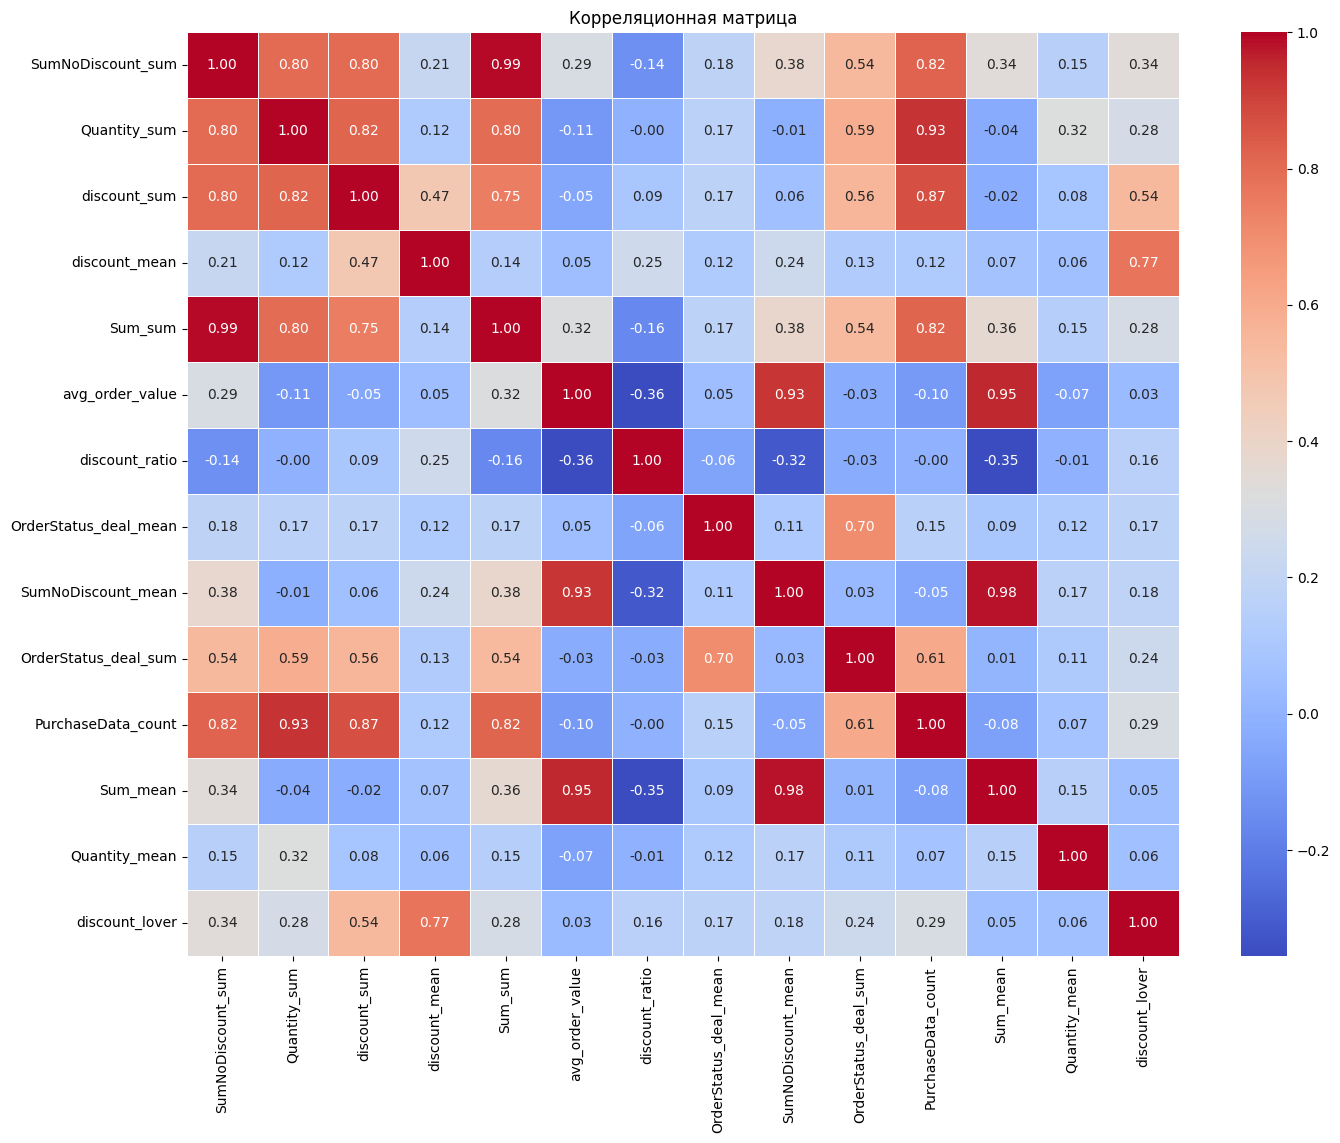

In [84]:
plt.figure(figsize=(16, 12))

# Select only numerical columns for correlation matrix calculation
numerical_X_reduced = X_reduced.select_dtypes(include=np.number)

# Ensure all numerical columns are explicitly float and handle potential errors
for col in numerical_X_reduced.columns:
    numerical_X_reduced[col] = pd.to_numeric(numerical_X_reduced[col], errors='coerce')

# Drop columns that became all NaN after coercion if necessary, or fill NaNs
numerical_X_reduced = numerical_X_reduced.dropna(axis=1, how='all')
numerical_X_reduced = numerical_X_reduced.fillna(numerical_X_reduced.mean()) # Fill remaining NaNs with mean, or choose another strategy

corr_matrix = numerical_X_reduced.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Корреляционная матрица")
plt.show()

In [ ]:
to_keep = ['avg_discount',
 'avg_spent',
 'total_spent',
 'avg_days_between_visits',
 'fav_category_МКТ',
 'purchase_count',
 'fav_category_Стельки',
 'total_quantity',
 'discount_lover',
 'fav_category_Ортопедия',
 'fav_category_Ко-продукты, МКТ',
 'fav_category_Обувь',
 'avg_quantity']

In [ ]:
X_reduced.describe()

# анализ 3

In [86]:
# Select only numerical columns and the target variable 'within_12m'
numerical_cols = client_features.select_dtypes(include=np.number).columns.tolist()
correlation_df = client_features[numerical_cols + ['target']]

# Calculate the correlation matrix
correlation_matrix = correlation_df.corr()

# Get correlations with the target variable 'within_12m' and sort using numpy
target_correlation = correlation_matrix['target']
sorted_indices = np.argsort(target_correlation.values[:, 0])[::-1] # Get indices of sorted values in descending order
target_correlation_sorted = target_correlation.iloc[sorted_indices]


print("Correlation with 'target':")
display(target_correlation_sorted)

# Clean up memory
#del df_colsel, correlation_df, correlation_matrix
#gc.collect()

Correlation with 'target':


,target,target
target,1.000000,1.000000
target,1.000000,1.000000
discount_sum,0.265118,0.265118
SumNoDiscount_sum,0.258841,0.258841
PurchaseData_count,0.255984,0.255984
Sum_sum,0.251787,0.251787
Quantity_sum,0.247339,0.247339
discount_lover,0.173480,0.173480
OrderStatus_deal_sum,0.167962,0.167962
discount_mean,0.131307,0.131307


In [ ]:
# Select columns with object or string data types as categorical
categorical_cols = df_saldeac.select_dtypes(include=['object', 'string', 'category']).columns.tolist()

print("Categorical columns in df_saldeac:")
print(categorical_cols)

Categorical columns in df_saldeac:
['GUID_Docum', 'Number', 'NumberOrder', 'Organization', 'Operation', 'GUID_warehouse', 'GUID_Product', 'DiscountName', 'LoyaltyProgram', 'GUID_DiscountCard', 'DiscountCard', 'GUID_client', 'ClientArrivalStatistics', 'Seller', 'TypeRetailSales', 'ClientsSources', 'OnlineCheck', 'reciept', 'ID_reciept', 'IN_reciept', 'SpecialtyGroupCRM', 'SpecialtyCRM', 'recieptCRM', 'ID_recieptCRM', 'TypeWorkIDCRM', 'Days_btw_deals', 'GUID_deal', 'Organization_deal', 'Operation_deal', 'Product_deal', 'DiscountName_deal', 'ClientArrivalStatistics_deal', 'Seller_deal', 'TypeRetailSales_deal', 'ClientsSources_deal', 'OnlineCheck_deal', 'reciept_deal', 'SpecialtyGroupCRM_deal', 'SpecialtyCRM_deal', 'MEDI_GMBH_deal', 'ModelRowBudget_deal', 'ItemType_deal', 'ClassCompression_deal', 'MacrogroupRS_deal', 'MicrogroupRS_deal', 'NanogroupRS_deal', 'Harmony_deal', 'KM_deal', 'WH_deal', 'City_deal', 'Dates_cl', 'OrderStatus_cl', 'OrdersDates_cl', 'Organization_cl', 'Operation_cl', 

In [ ]:
['GUID_Docum', 'Number', 'NumberOrder', 'Organization', 'Operation', 'GUID_warehouse', 'GUID_Product', 'DiscountName', 'LoyaltyProgram', 'GUID_DiscountCard', 'DiscountCard', 'GUID_client', 'ClientArrivalStatistics', 'Seller', 'TypeRetailSales', 'ClientsSources', 'OnlineCheck', 'reciept', 'ID_reciept', 'IN_reciept', 'SpecialtyGroupCRM', 'SpecialtyCRM', 'recieptCRM', 'ID_recieptCRM', 'TypeWorkIDCRM', 'Days_btw_deals', 'GUID_deal', 'Organization_deal', 'Operation_deal', 'Product_deal', 'DiscountName_deal', 'ClientArrivalStatistics_deal', 'Seller_deal', 'TypeRetailSales_deal', 'ClientsSources_deal', 'OnlineCheck_deal', 'reciept_deal', 'SpecialtyGroupCRM_deal', 'SpecialtyCRM_deal', 'MEDI_GMBH_deal', 'ModelRowBudget_deal', 'ItemType_deal', 'ClassCompression_deal', 'MacrogroupRS_deal', 'MicrogroupRS_deal', 'NanogroupRS_deal', 'Harmony_deal', 'KM_deal', 'WH_deal', 'City_deal', 'Dates_cl', 'OrderStatus_cl', 'OrdersDates_cl', 'Organization_cl', 'Operation_cl', 'Product_cl', 'DiscountName_cl', 'ClientArrivalStatistics_cl', 'Seller_cl', 'ClientsSources_cl', 'OnlineCheck_cl', 'reciept_cl', 'SpecialtyGroupCRM_cl', 'SpecialtyCRM_cl', 'DiscountList_cl', 'MEDI_GMBH_cl', 'ModelRowBudget_cl', 'ItemType_cl', 'ClassCompression_cl', 'MacrogroupRS_cl', 'MicrogroupRS_cl', 'NanogroupRS_cl', 'Harmony_cl', 'KM_cl', 'WH_cl', 'City_cl']

In [ ]:
chi_scores = chi2(X_encoded, df_saldeac['within_12m'])

# Выводим значимые признаки (p-value < 0.05)
significant_features = X_encoded.columns[chi_scores[1] < 0.05]
print("Значимые признаки:", significant_features.tolist())

Значимые признаки: ['Organization_Инновационные технологии ООО', 'GUID_warehouse_7d4b8ee8-a390-11ec-8119-6cae8b7d58ba', 'GUID_DiscountCard_2cff72aa-9afe-11ec-b4c2-2c4d5464ae83', 'GUID_DiscountCard_3f7efcb3-c088-11ec-ba9a-d850e63fe305', 'GUID_DiscountCard_4815b266-ab53-11ec-8605-e03f4978866a', 'GUID_DiscountCard_7086d983-edda-11eb-b597-acd564141872', 'GUID_DiscountCard_932da3f1-cb74-11ea-afc5-3052cb951c13', 'GUID_DiscountCard_OTHER', 'GUID_DiscountCard_d5607ef9-9c82-11ec-befe-f02f74ae4cff', 'GUID_DiscountCard_d7e0d8be-94b4-11ec-9b49-50465da1fa56', 'GUID_DiscountCard_e537aabd-a91d-11ec-9b52-50465da1fa56', 'DiscountCard_2500000639968', 'DiscountCard_8003770368822', 'DiscountCard_8012951291187', 'DiscountCard_8060331135569', 'DiscountCard_8072231193594', 'DiscountCard_8079111141843', 'DiscountCard_9029170706650', 'DiscountCard_9065450779914', 'DiscountCard_OTHER', 'GUID_client_0e98a0e0-079c-11e6-85ba-305a3a4badb5', 'GUID_client_68ffd994-dbaa-11e5-8982-c86000a191d4', 'GUID_client_8d4d3204-b

In [ ]:
interesting features = ['Days_btw_deals', 'Organization', 'GUID_warehouse', 'GUID_DiscountCard', 'DiscountCard', 'GUID_client', 'ClientArrivalStatistics', 'Seller', 'TypeRetailSales', 'SpecialtyGroupCRM', 'DiscountName_deal', 'ClassCompression_deal', 'MacrogroupRS_deal', 'Harmony_deal_Ко-Продукты', 'KM_deal', 'WH_deal', 'OrderStatus_cl', 'Operation_cl', 'DiscountName_cl', 'ClientsSources_cl', 'OnlineCheck_cl', 'SpecialtyGroupCRM_cl', 'SpecialtyCRM_cl', 'City_cl']

# lgb

In [114]:
params = {
    'objective': 'binary',           # Бинарная классификация
    'metric': 'auc',                 # Метрика - ROC-AUC
    'boosting_type': 'gbdt',         # Алгоритм градиентного бустинга
    'num_leaves': 31,                # Макс. количество листьев в дереве
    'learning_rate': 0.05,           # Скорость обучения
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'seed': 42,
    'verbose': -1,                   # Отключение логов
    'is_unbalance': True             # Автоматическая балансировка классов
}

In [116]:
datetime_cols = [ 'PurchaseData_min', 'PurchaseData_max']
for col in datetime_cols:
    # Проверяем, что столбец действительно содержит datetime
    if not pd.api.types.is_datetime64_any_dtype(X_train[col]):
        # Если нет, сначала конвертируем в datetime
        X_train[col] = pd.to_datetime(X_train[col])
        X_test[col] = pd.to_datetime(X_test[col])

    # Преобразуем в количество дней
    X_train[col] = (X_train[col] - pd.to_datetime('1970-01-01')).dt.days
    X_test[col] = (X_test[col] - pd.to_datetime('1970-01-01')).dt.days

categorical_cols = [col for col in X_train_r.columns if '_<lambda>' in col]
for col in categorical_cols:
    X_train_r[col] = X_train_r[col].astype('category')
    X_test_r[col] = X_test_r[col].astype('category')

train_data = lgb.Dataset(X_train_r, label=y_train, categorical_feature=categorical_cols)
test_data = lgb.Dataset(X_test_r, label=y_test, categorical_feature=categorical_cols, reference=train_data)



In [117]:
model = lgb.train(
    params=params,                    # Параметры модели
    train_set=train_data,             # Обучающие данные
    valid_sets=[test_data],           # Валидационные данные
    num_boost_round=1000,             # Количество итераций
)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 32126, number of negative: 116478
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.787618
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.257313
[LightGBM] [Debug] init for col-wise cost 0.020103 seconds, init for row-wise cost 0.083958 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 5427
[LightGBM] [Info] Number of data points in the train set: 148604, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore

In [118]:
y_pred_prob = model.predict(X_test_r)  # Вероятности класса 1
y_pred = (y_pred_prob > 0.5).astype(int)  # Бинарные предсказания

# ROC-AUC
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")

# Отчет по метрикам
print(classification_report(y_test, y_pred))

ROC-AUC: 0.7532
              precision    recall  f1-score   support

           0       0.88      0.76      0.82     29120
           1       0.42      0.61      0.50      8031

    accuracy                           0.73     37151
   macro avg       0.65      0.69      0.66     37151
weighted avg       0.78      0.73      0.75     37151



In [119]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {bal_acc:.4f}")

Accuracy: 0.7313
Balanced Accuracy: 0.6874


# оптимизация lgb

In [125]:
def objective(trial):
    # Параметры для оптимизации
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0),
        'verbosity': -1,
        'seed': 42
    }

    # Кросс-валидация (5 фолдов)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []

    for train_idx, valid_idx in cv.split(X_train_r, y_train):
        # Разделение данных
        X_tr, X_val = X_train_r.iloc[train_idx], X_train_r.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        # Создание Dataset
        train_data = lgb.Dataset(X_tr, label=y_tr, categorical_feature=categorical_cols)
        valid_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_cols, reference=train_data)

        # Обучение модели
        model = lgb.train(
            params,
            train_data,
            valid_sets=[valid_data],
        )

        # Прогноз и оценка
        y_pred = model.predict(X_val)
        auc_scores.append(roc_auc_score(y_val, y_pred))

    # Возвращаем средний AUC по фолдам
    return np.mean(auc_scores)

# Создание и запуск исследования Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600)  # 50 trials или 1 час

# Вывод результатов
print("Лучшие параметры:")
print(study.best_params)
print(f"Лучший AUC: {study.best_value:.4f}")

# Визуализация результатов
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_param_importances(study)

[I 2025-07-16 17:51:44,817] A new study created in memory with name: no-name-9a8b3817-ba59-42c0-9c01-bc93b9fce671
[I 2025-07-16 17:52:06,080] Trial 0 finished with value: 0.7729588121923034 and parameters: {'num_leaves': 269, 'learning_rate': 0.06829486692048531, 'feature_fraction': 0.618124067811784, 'bagging_fraction': 0.8673218948182237, 'bagging_freq': 4, 'min_child_samples': 16, 'max_depth': 5, 'reg_alpha': 6.090296252265121, 'reg_lambda': 6.7078643168838195, 'min_split_gain': 0.30105788264148337, 'scale_pos_weight': 3.120139548411128}. Best is trial 0 with value: 0.7729588121923034.
[I 2025-07-16 17:52:30,885] Trial 1 finished with value: 0.7726351217666318 and parameters: {'num_leaves': 98, 'learning_rate': 0.007331041431652148, 'feature_fraction': 0.7265982509679263, 'bagging_fraction': 0.8316132672231107, 'bagging_freq': 1, 'min_child_samples': 5, 'max_depth': 7, 'reg_alpha': 3.482150981588097, 'reg_lambda': 7.908077542552789, 'min_split_gain': 0.6646623415158196, 'scale_pos_w

Лучшие параметры:
{'num_leaves': 49, 'learning_rate': 0.037071231134422906, 'feature_fraction': 0.5020285556929693, 'bagging_fraction': 0.5485957050247876, 'bagging_freq': 5, 'min_child_samples': 14, 'max_depth': 10, 'reg_alpha': 2.35196708472028, 'reg_lambda': 9.980000171556522, 'min_split_gain': 0.2294724048775584, 'scale_pos_weight': 1.0142830776042404}
Лучший AUC: 0.7751


In [ ]:
{'num_leaves': 49, 'learning_rate': 0.037071231134422906, 'feature_fraction': 0.5020285556929693, 'bagging_fraction': 0.5485957050247876, 'bagging_freq': 5, 'min_child_samples': 14, 'max_depth': 10, 'reg_alpha': 2.35196708472028, 'reg_lambda': 9.980000171556522, 'min_split_gain': 0.2294724048775584, 'scale_pos_weight': 1.0142830776042404}

In [ ]:
y_pred_prob = model.predict(X_test_r)  # Вероятности класса 1
y_pred = (y_pred_prob > 0.5).astype(int)  # Бинарные предсказания

# ROC-AUC
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")

# Отчет по метрикам
print(classification_report(y_test, y_pred))

In [148]:
# 1. Убедимся, что параметры установлены ДО создания Dataset
bestparams = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 49,
    'learning_rate': 0.037,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.55,
    'bagging_freq': 5,
    'min_child_samples': 14,
    'max_depth': 10,
    'reg_alpha': 2.35,
    'reg_lambda': 9.980,
    'min_split_gain': 0.23,
    'scale_pos_weight': 1.01,
    'feature_pre_filter': False,  # Должно быть установлено здесь
    'verbosity': -1,
    'seed': 42
}

# 2. Создаем Dataset с указанием категориальных признаков
# Убедитесь, что categorical_cols содержит правильные имена столбцов
train_data = lgb.Dataset(
    X_train_r,
    label=y_train,
    categorical_feature=categorical_cols,  # Указываем категориальные признаки
    params={'feature_pre_filter': False}  # Дополнительное подтверждение
)

test_data = lgb.Dataset(
    X_test_r,
    label=y_test,
    categorical_feature=categorical_cols,
    reference=train_data  # Важно для консистентности категорий
)

# 3. Обучение модели
model = lgb.train(
    params=bestparams,
    train_set=train_data,
    valid_sets=[test_data],
    num_boost_round=1000,
)


In [158]:

y_pred_prob = model.predict(X_test_r)  # Вероятности класса 1
y_pred = (y_pred_prob > 0.4).astype(int)   # Бинарные предсказания (порог 0.5)

# 2. Расчет метрик
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}\n")



Accuracy: 0.7947
Balanced Accuracy: 0.6504

